In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
# Constantes
pares_cines_dict = {
    "amplio": {"cine": "cine_f_2013_ac_campo_amplio", "icine": "icine_amplio"},
    "especifico": {"cine": "cine_f_2013_ac_campo_especific", "icine": "icine_spec"},
    "detallado": {"cine": "cine_f_2013_ac_campo_detallado", "icine": "icine_detall"}
}

# Funciones
def resumen_nans(df):
    summary = []
    for col in df.columns:
        summary.append({
            "column": col,
            "class": df[col].dtype.name,
            "NA_count": df[col].isna().sum(),
            "NaN_count": df[col].isna().sum() if df[col].dtype.kind in 'fc' else 0
        })
    return pd.DataFrame(summary)

def detectar_valores_no_emparejados(tabla_referencia, tabla_comparacion,
                                     columna_referencia, columna_comparacion,
                                     incluir_filas_afectadas=False):
    valores_ref = tabla_referencia[columna_referencia].dropna().unique()
    valores_comp = tabla_comparacion[columna_comparacion].dropna().unique()
    
    sin_match_ref = np.setdiff1d(valores_ref, valores_comp)
    sin_match_comp = np.setdiff1d(valores_comp, valores_ref)

    resultado = {
        "valores_sin_correspondencia_referencia": sin_match_ref,
        "cantidad_valores_sin_correspondencia_referencia": len(sin_match_ref),
        "valores_sin_correspondencia_comparacion": sin_match_comp,
        "cantidad_valores_sin_correspondencia_comparacion": len(sin_match_comp),
    }

    if incluir_filas_afectadas:
        filas_afectadas_ref = tabla_referencia[tabla_referencia[columna_referencia].isin(sin_match_ref)]
        filas_afectadas_comp = tabla_comparacion[tabla_comparacion[columna_comparacion].isin(sin_match_comp)]
        resultado.update({
            "cantidad_filas_afectadas_referencia": len(filas_afectadas_ref),
            "filas_afectadas_referencia": filas_afectadas_ref,
            "cantidad_filas_afectadas_comparacion": len(filas_afectadas_comp),
            "filas_afectadas_comparacion": filas_afectadas_comp
        })
    
    return resultado

def resumir_por_cine(df, cine, icine, nivel_filtrado=None):
    if nivel_filtrado:
        df = df[df['nivel_de_formacion'].isin([nivel_filtrado])]
    
    grouped = df.groupby([cine, icine])
    resumen = grouped.agg(
        n_estudiantes=('punt_global', 'count'),
        promedio_punt_saberpro=('punt_global', 'mean'),
        codigo_institucion=('codigo_institucion','first'),
        nombre_institucion=('nombre_institucion', 'first'),
        snies_programa=('estu_snies_prgmacademico', lambda x: "; ".join(map(str, x.unique()))),
        conteo_por_programa=('estu_snies_prgmacademico', lambda x: dict(x.value_counts())),
        nombre_del_programa=('nombre_del_programa', lambda x: "; ".join(x.unique())),
        periodo=('año_presentacion', 'first')
    ).reset_index()
    return resumen

def resumen_programas_con_info_cine(df, cine, nivel_filtrado=None):
    if nivel_filtrado:
        df = df[df['nivel_de_formacion'].isin([nivel_filtrado])]

    # 1️⃣ Resumen por CINE
    resumen_cine = df.groupby(cine).agg(
        promedio_cine=('punt_global', 'mean'),
        n_estudiantes_cine=('punt_global', 'count')
    ).reset_index()

    # 2️⃣ Resumen por PROGRAMA dentro del CINE
    resumen_prog = df.groupby([cine, 'estu_snies_prgmacademico']).agg(
        promedio_programa=('punt_global', 'mean'),
        codigo_institucion=('codigo_institucion', 'first'),
        nombre_institucion=('nombre_institucion', 'first'),
        nombre_del_programa=('nombre_del_programa', 'first'),
        n_estudiantes_programa=('punt_global', 'count'),
        periodo=('año_presentacion', 'first')
    ).reset_index()

    # 3️⃣ Unir ambos resúmenes para que cada programa tenga la info de su cine
    resumen_final = resumen_prog.merge(resumen_cine, on=cine, how='left')

    return resumen_final


def resumir_por_programa(df):
    resumen = df.groupby(
        ["codigo_snies_del_programa", "nombre_del_programa"],
        dropna=False
    ).agg(
        n_estudiantes=('punt_global', 'count'),
        promedio_punt_saberpro=('punt_global', 'mean'),
        n_estudiantes_matriculados=(
            'periodo',
            lambda x: sum(str(p)[-1] == "1" for p in x if pd.notnull(p))
        ),
        nombre_institucion=('nombre_institucion', 'first'),
        periodo=('año_presentacion', 'first')
    ).reset_index()
    
    return resumen

def exportar_resumenes(lista_resumenes, grupo_sufijo):
    carpeta_salida = Path("data/Promedios")
    carpeta_salida.mkdir(parents=True, exist_ok=True)
    
    for nombre, df in lista_resumenes.items():
        filename = f"promedios_cine{nombre}_{grupo_sufijo}.csv"
        ruta = carpeta_salida / filename
        df.to_csv(ruta, index=False)
        print(f"Exportado: {ruta}")

In [3]:
# Lectura de datos
base_saber_pro = pd.read_csv("../../data/SABERPRO_cleaned/base_sbpro_bogota_region_corte_01082025.csv")
programas = pd.read_csv("../../data/SNIES_CINE_cleaned/base_snies_sbpro_bogota_region_corte_01082025.csv")

**El 1 de octubre se solicitó cambiar el codigo snies del programa 91238  por 106242**

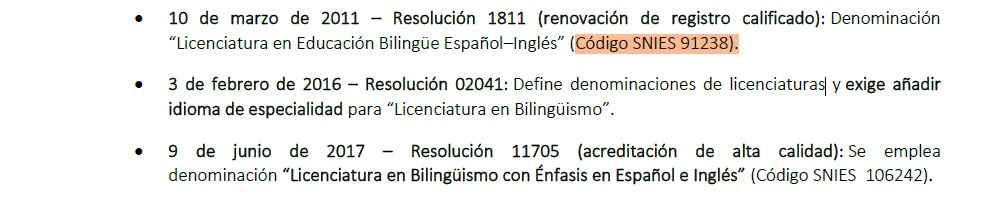

In [4]:
### reemplazo del codigo snies
mappings = {
    "estu_snies_prgmacademico": {91238: 106242},
    "codigo_snies_del_programa": {91238: 106242}
}

# aplicar directamente sin loops
base_saber_pro["estu_snies_prgmacademico"] = (
    base_saber_pro["estu_snies_prgmacademico"].replace(mappings["estu_snies_prgmacademico"])
)

programas["codigo_snies_del_programa"] = (
    programas["codigo_snies_del_programa"].replace(mappings["codigo_snies_del_programa"])
)

In [6]:
data = pd.merge(
    base_saber_pro,
    programas,
    left_on="estu_snies_prgmacademico",
    right_on="codigo_snies_del_programa",
    how="left"
)

data['año_presentacion'] = data['periodo']//10
data["codigo_snies_del_programa"] = pd.to_numeric(data["codigo_snies_del_programa"], errors="coerce").astype("Int64")
data["codigo_institucion"] = pd.to_numeric(data["codigo_institucion"], errors="coerce").astype("Int64")

In [7]:
data = data[
    data["codigo_snies_del_programa"].notna() &
    data["codigo_institucion"].notna() &
    (data["estado_programa"] == "Activo") &
    (data["nivel_de_formacion"] == "Universitario") &
    (data["nivel_academico"] == "Pregrado")
]

In [8]:
# Validación de emparejamiento
no_emparejados = detectar_valores_no_emparejados(
    base_saber_pro, programas,
    "estu_snies_prgmacademico", "codigo_snies_del_programa"
)
print("No emparejados (referencia):", no_emparejados["cantidad_valores_sin_correspondencia_referencia"])
print("No emparejados (comparación):", no_emparejados["cantidad_valores_sin_correspondencia_comparacion"])

No emparejados (referencia): 371
No emparejados (comparación): 362


In [9]:
# Resumen de nans
data_summary = resumen_nans(data)

In [10]:
#crear llave IES-SNIES
#data['codies_codsnies'] = data["codigo_institucion"].astype(str) + "_" + data["estu_snies_prgmacademico"].astype(str)
# Crear variables icine
data["icine_spec"] = data["codigo_institucion"].astype(str) + "_" + data["cine_f_2013_ac_campo_especific"].astype(str)
data["icine_detall"] = data["codigo_institucion"].astype(str) + "_" + data["cine_f_2013_ac_campo_detallado"].astype(str)
data["icine_amplio"] = data["codigo_institucion"].astype(str) + "_" + data["cine_f_2013_ac_campo_amplio"].astype(str)

# Calcular resumen por icine
años = [2020, 2021, 2022, 2023]
cines_para_resumir = ["detallado"]
consolidado = []

for año in años:
    data_temp = data[data["año_presentacion"] == año]

    resumenes_universitario = {
        nombre: resumir_por_cine(
            data_temp,
            pares_cines_dict[nombre]["cine"],
            pares_cines_dict[nombre]["icine"]
        )
        for nombre in cines_para_resumir
    }

    # Agregar los dataframes a la lista de consolidación
    for df in resumenes_universitario.values():
        consolidado.append(df)
        
    #exportar_resumenes(resumenes_universitario, f"tecnico_{año}")

base_universitario = pd.concat(consolidado, ignore_index=True)


In [11]:
base_universitario.head()

,cine_f_2013_ac_campo_detallado,icine_detall,n_estudiantes,promedio_punt_saberpro,codigo_institucion,nombre_institucion,snies_programa,conteo_por_programa,nombre_del_programa,periodo
0,Adquisicion Del Lenguaje,1101_Adquisicion Del Lenguaje,83,191.566265,1101,Universidad Nacional De Colombia,23.0,{23.0: 83},Filologia E Idiomas,2020
1,Agropecuario No Clasificado En Otra Parte,2829_Agropecuario No Clasificado En Otra Parte,43,152.860465,2829,Corporacion Universitaria Minuto De Dios -Unim...,8903.0,{8903.0: 43},Ingenieria Agroecologica,2020
2,Arquitectura Y Urbanismo,1101_Arquitectura Y Urbanismo,96,182.072917,1101,Universidad Nacional De Colombia,30.0,{30.0: 96},Arquitectura,2020
3,Arquitectura Y Urbanismo,1121_Arquitectura Y Urbanismo,93,145.860215,1121,Universidad-Colegio Mayor De Cundinamarca,4770.0,{4770.0: 93},Construccion Y Gestion En Arquitectura,2020
4,Arquitectura Y Urbanismo,1714_Arquitectura Y Urbanismo,27,180.000000,1714,Colegio Mayor De Nuestra Senora Del Rosario,51641.0,{51641.0: 27},Gestion Y Desarrollo Urbanos,2020


quería pedirte de vuelta las bases de saber Pro y saber TyT. Pero con la llave tanto de codigo IES; como codigos SNIES del programa. promediado a nivel de CINE F13 AC pero a nivel de programa. Y a parte del promedio el número de estudiantes que presentaron saber pro, tanto a nivel de programa como a nivel de CINE F13 AC. 

### Pivot tables de los ICINE

In [12]:
# Paso 1: Pivotear la tabla
pivot_universitario = base_universitario.pivot_table(
    index=["icine_detall"],     # o "icine_spec", "icine_detall", según el que quieras analizar
    columns="periodo",
    values="promedio_punt_saberpro"
)

pivot_universitario['NF'] = "Universitario"

In [13]:
pivot_universitario.head()

periodo,2020,2021,2022,2023,NF
icine_detall,,,,,
1101_Adquisicion Del Lenguaje,191.566265,179.098901,187.800000,184.838710,Universitario
1101_Arquitectura Y Urbanismo,182.072917,181.471910,182.290323,176.601562,Universitario
1101_Artes No Clasificadas En Otra Parte,175.384615,174.628571,179.470588,184.651163,Universitario
1101_Bellas Artes,186.875000,182.605263,172.370370,178.357143,Universitario
1101_Biologia,192.693333,182.383333,187.718750,183.961039,Universitario


In [14]:
from datetime import datetime

# Generate today's date string in DDMMYYYY format
fecha_hoy = datetime.today().strftime('%d%m%Y')

pivot_universitario.to_excel(
    f"../../data/Promedios/icine4d_universitario_bogota_region_corte_{fecha_hoy}.xlsx", index=True
)

### Resumen por programa

In [15]:
##################################
# Resumen por programa
##################################
años = [2020, 2021, 2022, 2023,2024]
consolidado = []
for año in años:
    data_temp = data[data["año_presentacion"] == año].copy()
    promedios_programa = resumir_por_programa(data_temp)
    consolidado.append(promedios_programa)

In [20]:
base_programas = pd.concat(consolidado, ignore_index=True)

In [21]:
# Paso 1: Pivotear la tabla
pivot_base_programas = base_programas.pivot_table(
    index=["codigo_snies_del_programa"],     # o "icine_spec", "icine_detall", según el que quieras analizar
    columns="periodo",
    values="promedio_punt_saberpro"
)

In [22]:
from datetime import datetime

# Generate today's date string in DDMMYYYY format
fecha_hoy = datetime.today().strftime('%d%m%Y')

pivot_base_programas.to_excel(
    f"../../data/Promedios/programas_sbpro_bogota_region_corte_{fecha_hoy}.xlsx", 
    index=True
)

### Resumen por Programa con promedio de CINE y Programa

In [23]:
#crear llave IES-SNIES
#data['codies_codsnies'] = data["codigo_institucion"].astype(str) + "_" + data["estu_snies_prgmacademico"].astype(str)
# Crear variables icine
data["icine_spec"] = data["codigo_institucion"].astype(str) + "_" + data["cine_f_2013_ac_campo_especific"].astype(str)
data["icine_detall"] = data["codigo_institucion"].astype(str) + "_" + data["cine_f_2013_ac_campo_detallado"].astype(str)
data["icine_amplio"] = data["codigo_institucion"].astype(str) + "_" + data["cine_f_2013_ac_campo_amplio"].astype(str)

# Calcular resumen por icine
años = [2020, 2021, 2022, 2023,2024]
cines_para_resumir = ["detallado"]
consolidado = []

for año in años:
    data_temp = data[data["año_presentacion"] == año]

    resumenes_universitario = {
        nombre: resumen_programas_con_info_cine(
            data_temp,
            pares_cines_dict[nombre]["cine"],
        )
        for nombre in cines_para_resumir
    }

    # Agregar los dataframes a la lista de consolidación
    for df in resumenes_universitario.values():
        consolidado.append(df)
        
    #exportar_resumenes(resumenes_universitario, f"tecnico_{año}")

base_universitario = pd.concat(consolidado, ignore_index=True)

In [24]:
from datetime import datetime
column_order = [
    #'cine_f_2013_ac_campo_detallado',
    'estu_snies_prgmacademico',
    'nombre_del_programa',
    'codigo_institucion',
    'nombre_institucion',
    'n_estudiantes_programa',
    'n_estudiantes_cine',
    'promedio_programa',
    'promedio_cine',
    'periodo',
]

# Generate today's date string in DDMMYYYY format
fecha_hoy = datetime.today().strftime('%d%m%Y')

base_universitario.to_excel(
    f"../../data/Promedios/cine4d_universitario_bogota_region_{fecha_hoy}.xlsx",
    columns = column_order,
    index=False)


In [25]:
base_universitario.tail()

,cine_f_2013_ac_campo_detallado,estu_snies_prgmacademico,promedio_programa,codigo_institucion,nombre_institucion,nombre_del_programa,n_estudiantes_programa,periodo,promedio_cine,n_estudiantes_cine
5070,Veterinaria,2.0,177.388889,1101,Universidad Nacional De Colombia,Medicina Veterinaria,72,2024,155.902192,593
5071,Veterinaria,1433.0,163.025478,1803,Universidad De La Salle,Medicina Veterinaria,157,2024,155.902192,593
5072,Veterinaria,4356.0,147.480916,1826,Universidad Antonio Narino,Medicina Veterinaria,131,2024,155.902192,593
5073,Veterinaria,21474.0,150.425743,1835,Universidad De Ciencias Aplicadas Y Ambientale...,Medicina Veterinaria,101,2024,155.902192,593
5074,Veterinaria,101816.0,148.257576,2723,Fundacion Universitaria Agraria De Colombia -U...,Medicina Veterinaria,132,2024,155.902192,593
